```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

This notebook is prototypes how the model error behaves in a case
where the direction towards north varies across the domain


This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Testing the Model Error

## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc, colors, cm
from matplotlib import pyplot as plt

import os
import datetime
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

#Import our simulator
from SWESimulators import CDKLM16, OceanStateNoise, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%cuda_context_handler gpu_ctx

8.049280691911079 -6.549678292808527


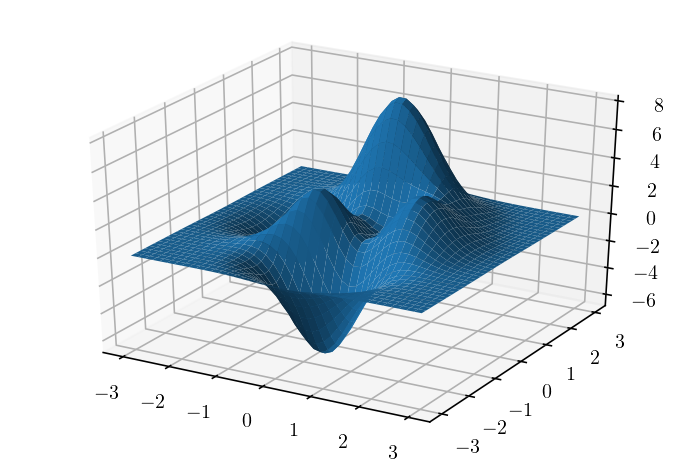

In [3]:
# For bathymetry
def peaks(nx, ny):
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-3, 3, ny)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2*np.exp(-(x**2) - (y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)
    return x, y, z


from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = peaks(40, 40)
ax.plot_surface(x, y, z)

print(np.max(z), np.min(z))

In [4]:
width = 500000
height = 500000

#domain_min = 16
domain_min = 128
domain_max = 1024
domain_size = 180#*4
    
g = 9.81
r = 0.00
f = 1.0e-4
beta = 1.0e-11

end_time = 1600.0

In [5]:
def averageFV(highres_solution, factor):
    NX = highres_solution.shape[1]
    NY = highres_solution.shape[0]
    
    assert(NY % factor == 0)
    assert(NX % factor == 0)
    
    nx = int(NX / factor)
    ny = int(NY / factor)
    
    factor = int(factor)
    
    return  highres_solution.reshape([ny, factor, nx, factor]).mean(3).mean(1)


def averageFD(highres_solution, factor):
    target = highres_solution.shape[0] / factor
    while (highres_solution.shape[0] > target):
        highres_solution = highres_solution[::2, ::2]
    return highres_solution

FV: Max=0.99947, min=0.00000, sum=0.0840758905
from initAngle - min, max of x before arccos:  -0.8320502943378437 0.4472135954999579
Angle: Max=0.98279, min=-0.46365, sum=0.2419735210
min, max, shape of angle:  -0.46364760900080615 0.9827937232473292 (180, 180)


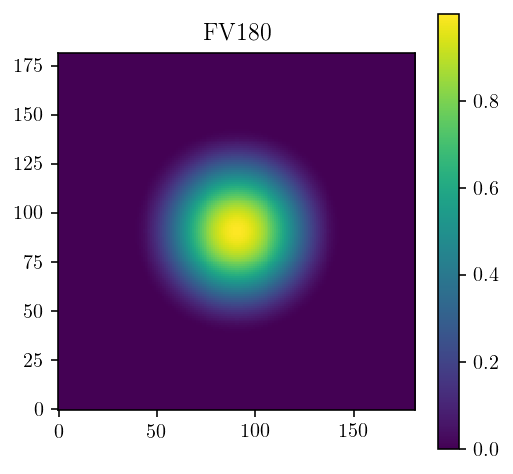

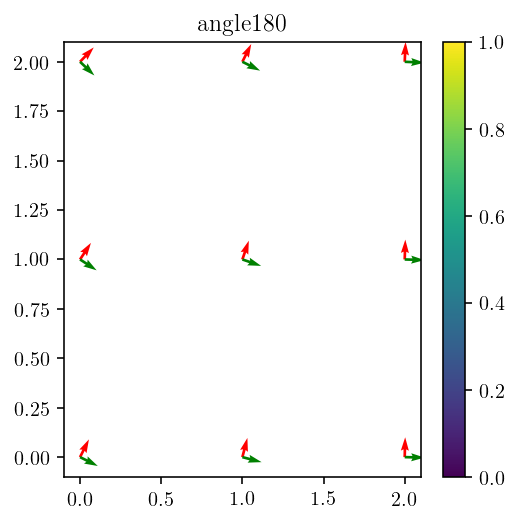

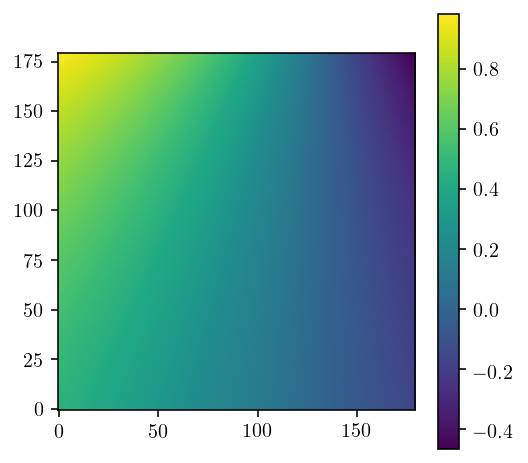

In [6]:
def initH(h0, ghosts, reference_domain_size):    
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = h0.shape[1] - ghosts[0] - ghosts[2]
    ny = h0.shape[0] - ghosts[1] - ghosts[3]
    
    _, _, z = peaks(ref_nx, ref_ny)
    z = averageFD(z, ref_nx/nx)
    h0.fill(100.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    h0[y0:y1, x0:x1] = h0[y0:y1, x0:x1] + z*10
    
    return h0
    
x = np.zeros((8, 8))
initH(x, [0, 0, 0, 0], 64)
    
def initAngle(angle):
    ny, nx = angle.shape
    
    #North pole
    x0 = 0.5
    y0 = 2.0
    
    #Vector to north
    x = np.linspace(-1, 1, nx) - x0
    y = np.linspace(-1, 1, ny) - y0
    x, y = np.meshgrid(x, y)
    
    #Normalize
    l = np.sqrt(x**2 + y**2)
    x = x/l
    y = y/l
    
    print('from initAngle - min, max of x before arccos: ', x.min(), x.max())
    
    angle.fill(-np.pi/2)
    angle = angle + np.arccos(x)
    
    return angle
    
    
def initEtaFV(eta0, ghosts, reference_domain_size):
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = eta0.shape[1] - ghosts[0] - ghosts[2]
    ny = eta0.shape[0] - ghosts[1] - ghosts[3]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i + 0.5 - ref_nx/2.0) / float(ref_nx)
        y = 2*(j + 0.5 - ref_ny/2.0) / float(ref_ny)
        r = np.sqrt(x**2 + y**2)
        return (1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    disturbance = np.fromfunction(lambda i, j: my_cos(i,j), (ref_ny, ref_nx))
    disturbance = averageFV(disturbance, ref_nx/nx) 
    
    eta0.fill(0.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    eta0[y0:y1, x0:x1] += (0.5*disturbance)
    
    #Make sure solution is symmetric
    eta0 = 0.5*(eta0 +  eta0[::-1, ::-1])
    

    
def initHU(hu0, ghosts):
    hu0.fill(0.0)
    
def initHV(hv0, ghosts):
    hv0.fill(0.0)

def testInitDataFV(domain_size, reference_domain_size):
    nx = domain_size
    ny = domain_size
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])
    eta0 = np.zeros(dataShape, dtype=np.float32);
    initEtaFV(eta0, ghosts, reference_domain_size)
    return eta0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]
     
plt.figure(figsize=(4,4))
eta0 = testInitDataFV(domain_size, domain_size*2)
plt.imshow(eta0, interpolation='nearest', origin='lower')
plt.title("FV"+str(domain_size))
print("FV: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
plt.colorbar()

   
plt.figure(figsize=(4,4))
angle = np.empty((domain_size, domain_size))
angle = initAngle(angle)
#plt.imshow(angle, interpolation='nearest', origin='lower')
#plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8)
plt.quiver(np.sin(angle[::64, ::64]), np.cos(angle[::64, ::64]), color='r')
plt.quiver(np.cos(angle[::64, ::64]), -np.sin(angle[::64, ::64]), color='g')
plt.title("angle"+str(domain_size))
print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
plt.colorbar()
    
plt.figure(figsize=(4,4))
plt.imshow(angle, origin='lower', interpolation='None')
plt.colorbar()
print("min, max, shape of angle: ", angle.min(), angle.max(), angle.shape)

    

## CDKLM 16

from initAngle - min, max of x before arccos:  -0.8320502943378437 0.4472135954999579
min, max, shape of angle:  -0.4636476527121962 0.9827936795359391 (184, 184)
-np.pi/2: -1.5707963267948966
nx, ny 180 180
dx, dy 2777.7778 2777.7778
domain size (Lx, Ly): (500000.009765625, 500000.009765625)
f, beta 9.992546e-05 1e-11
Hi.shape, Hm.shape (182, 182) (180, 180)
min, max of hu:     -0.73428696 0.9057897
min, max of hv:     -0.88634837 0.8984213
min, max of angle:  -0.4636476527121962 0.9827936795359391
error norm:     0.0049652546
rel error norm: 0.13229714


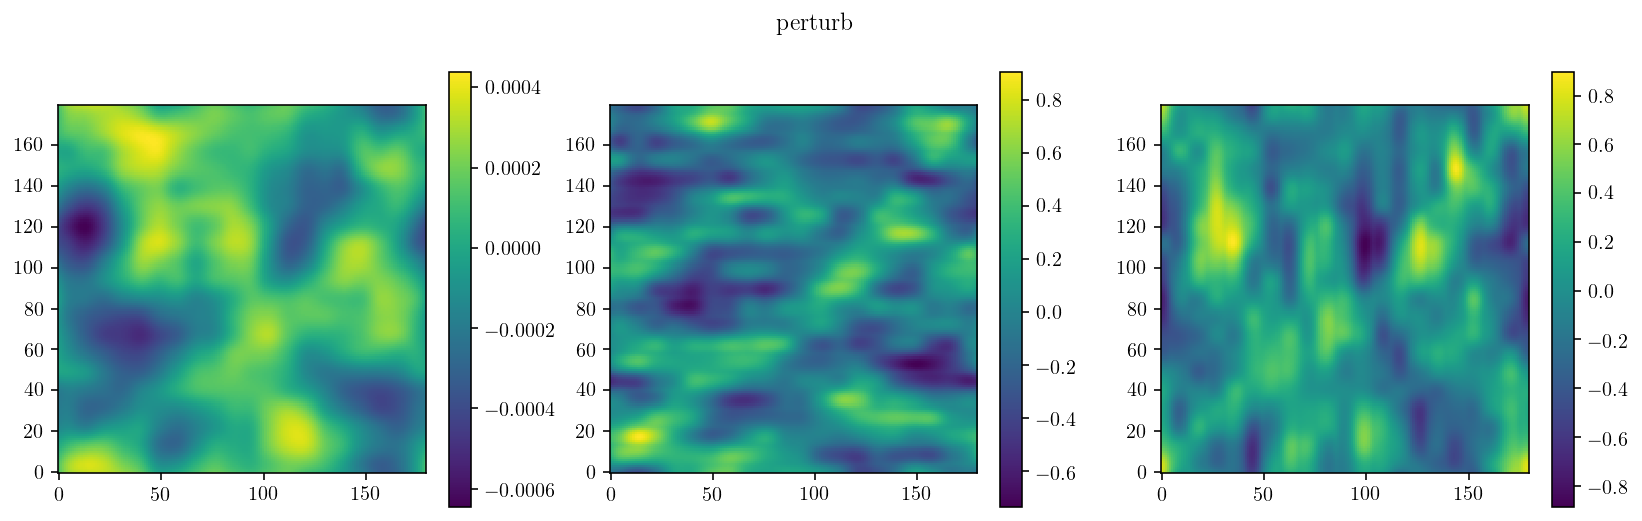

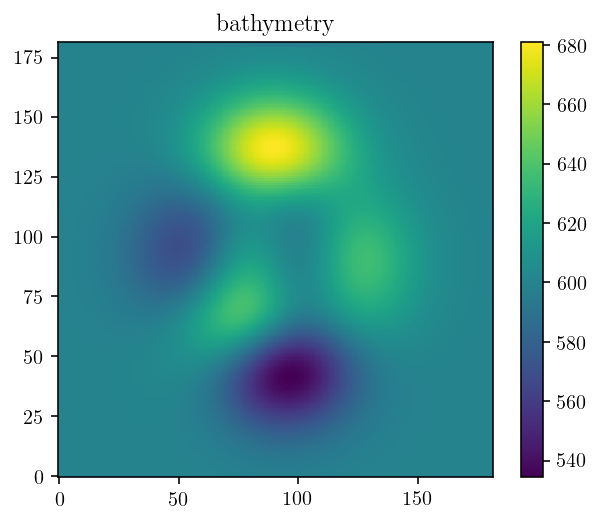

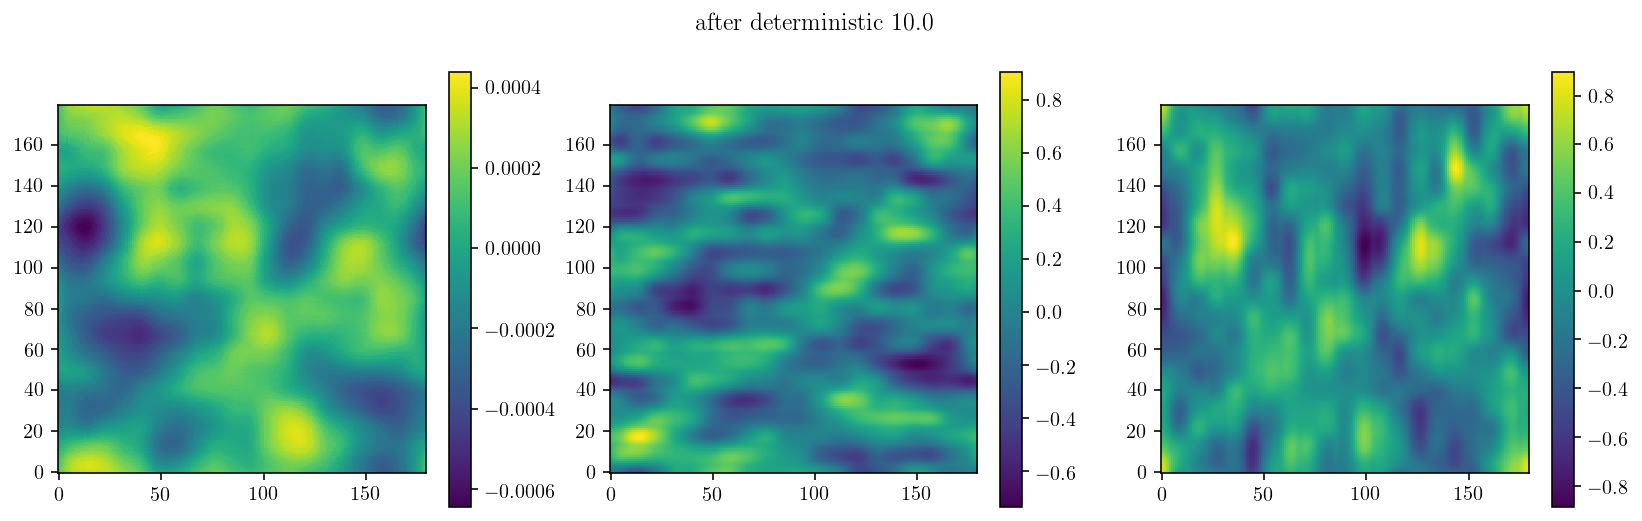

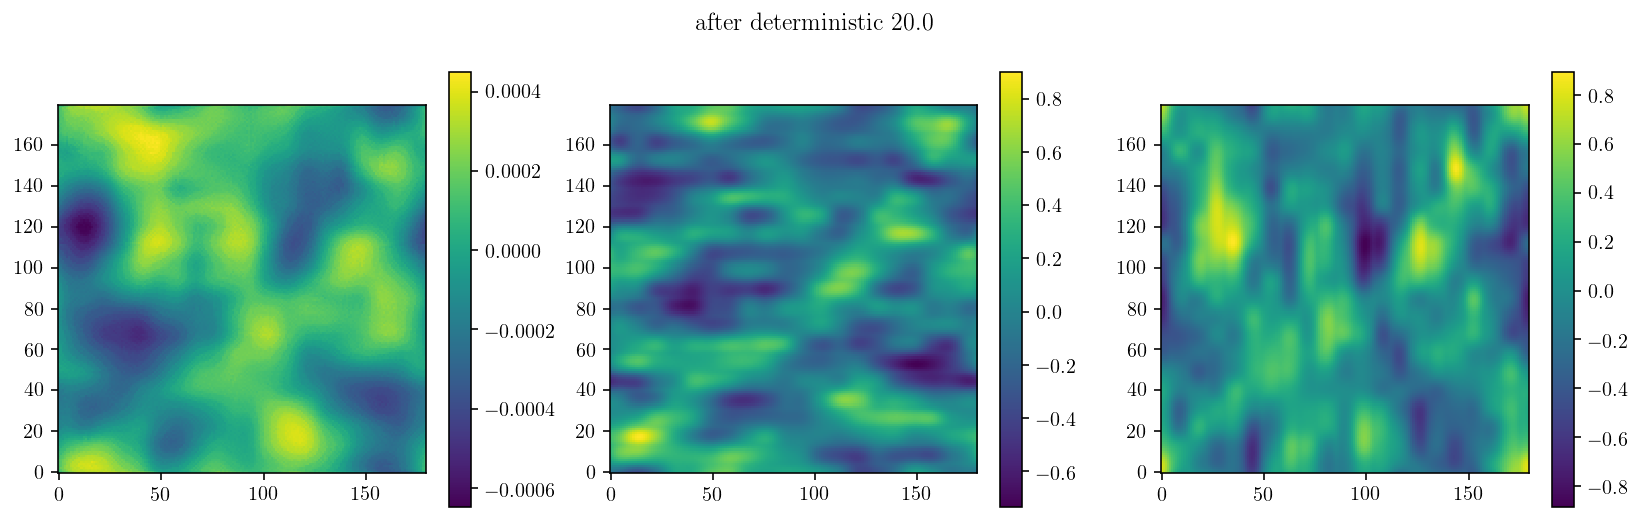

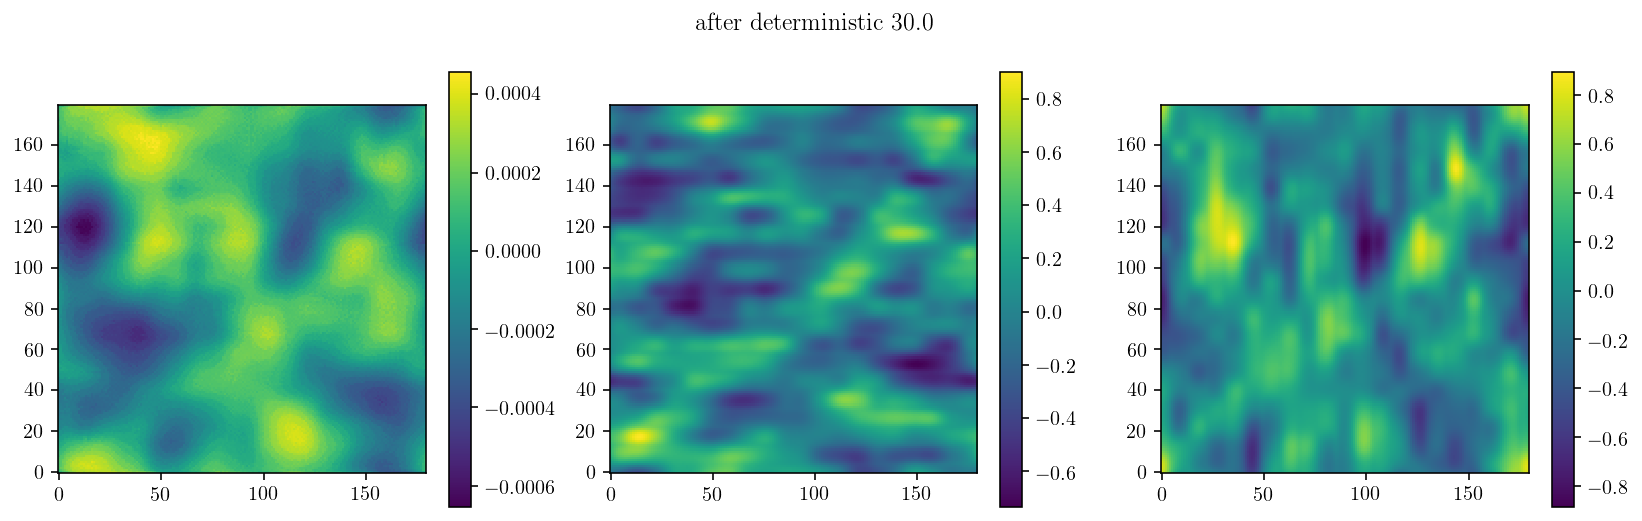

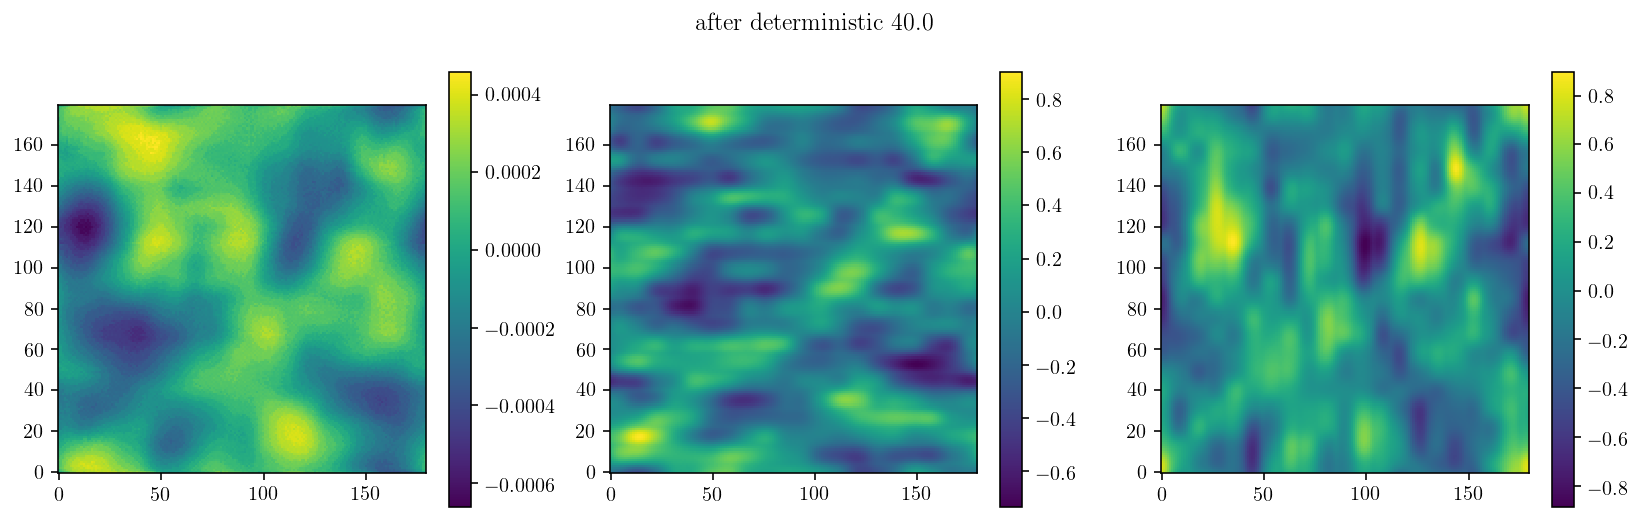

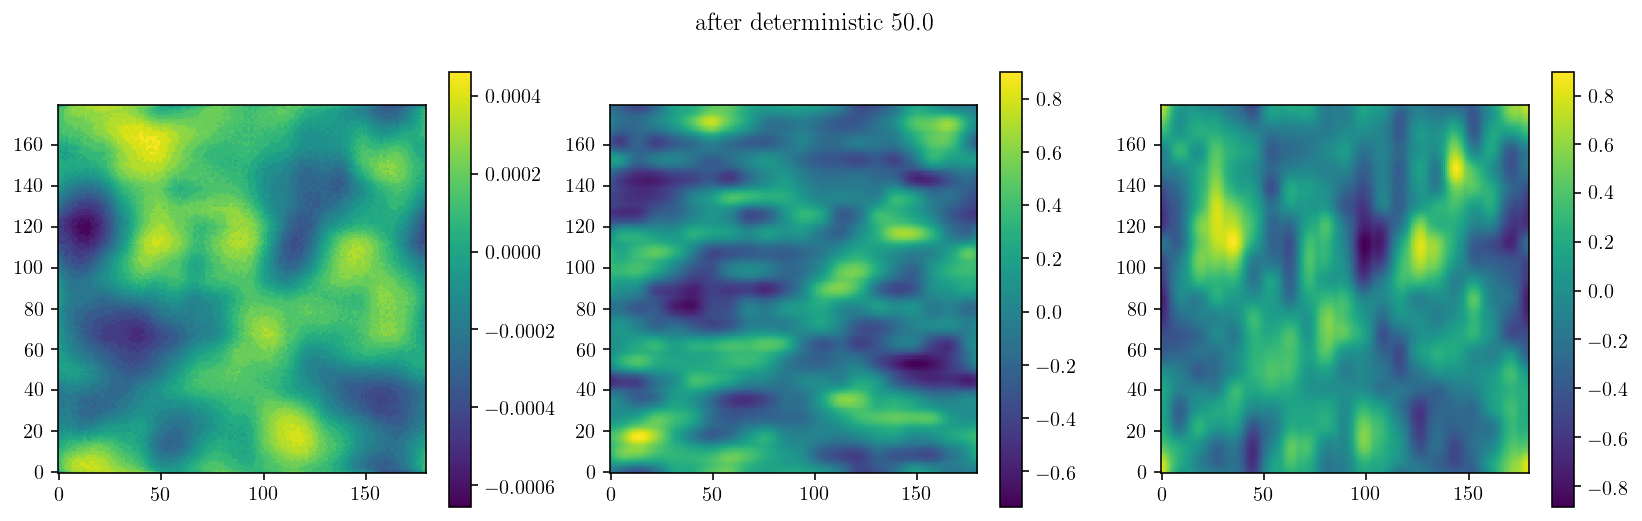

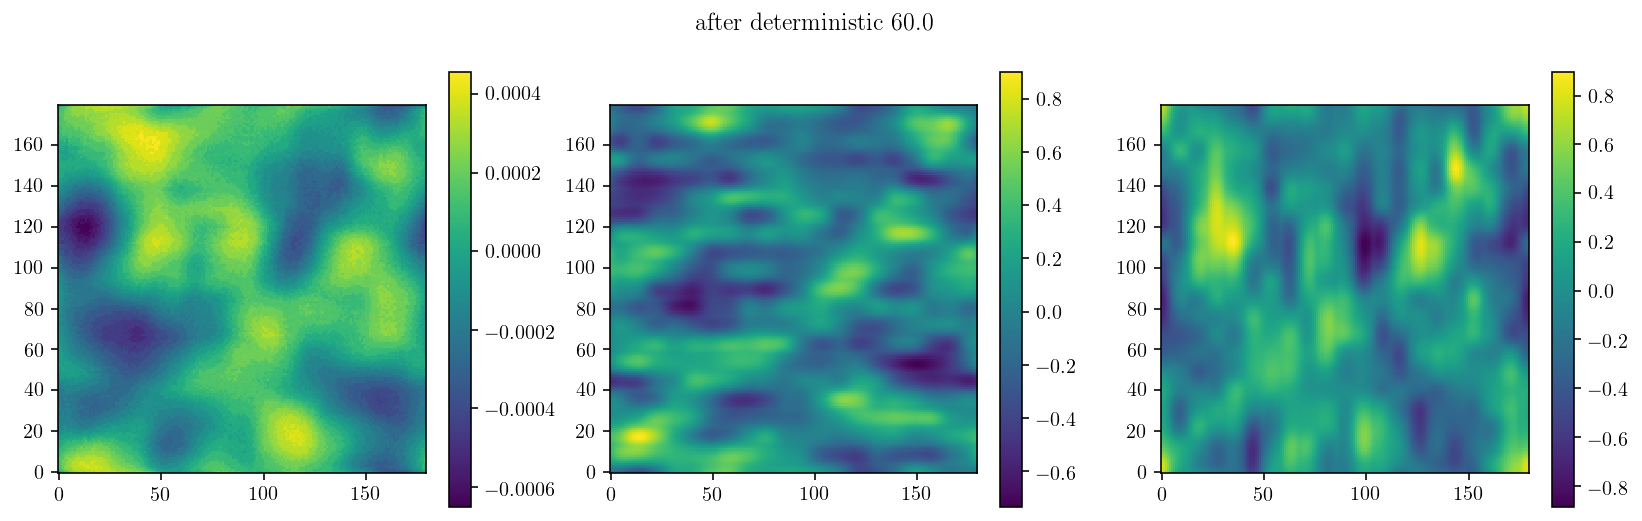

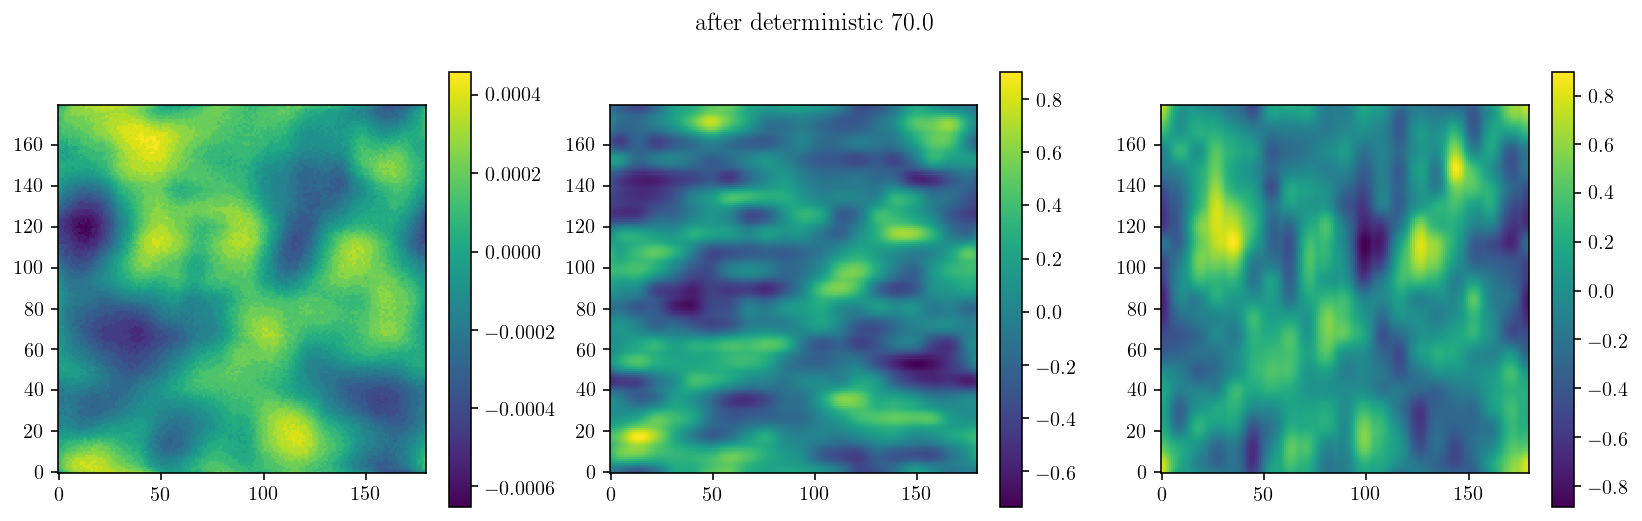

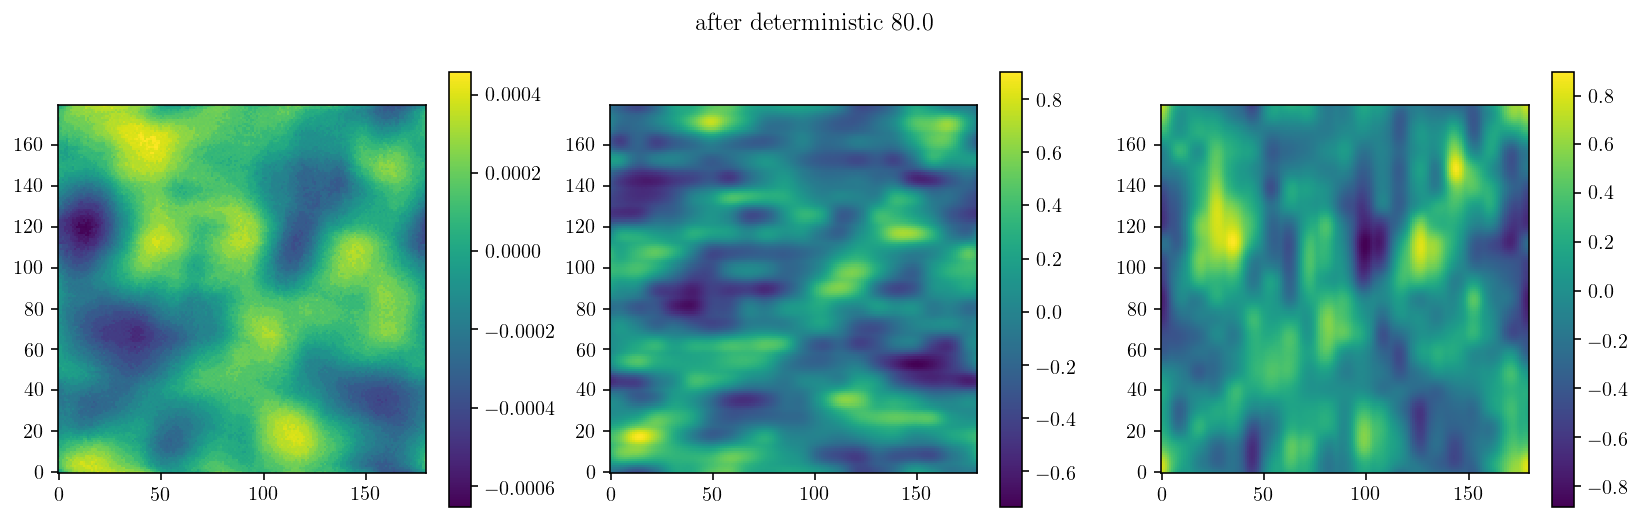

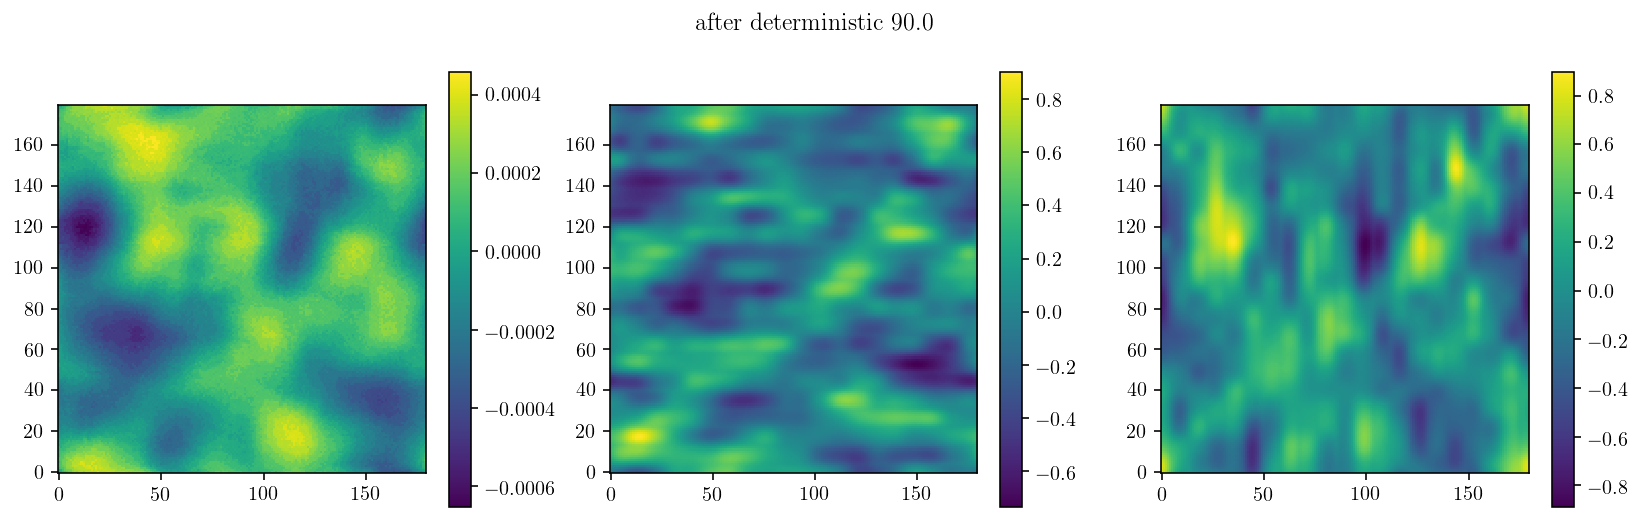

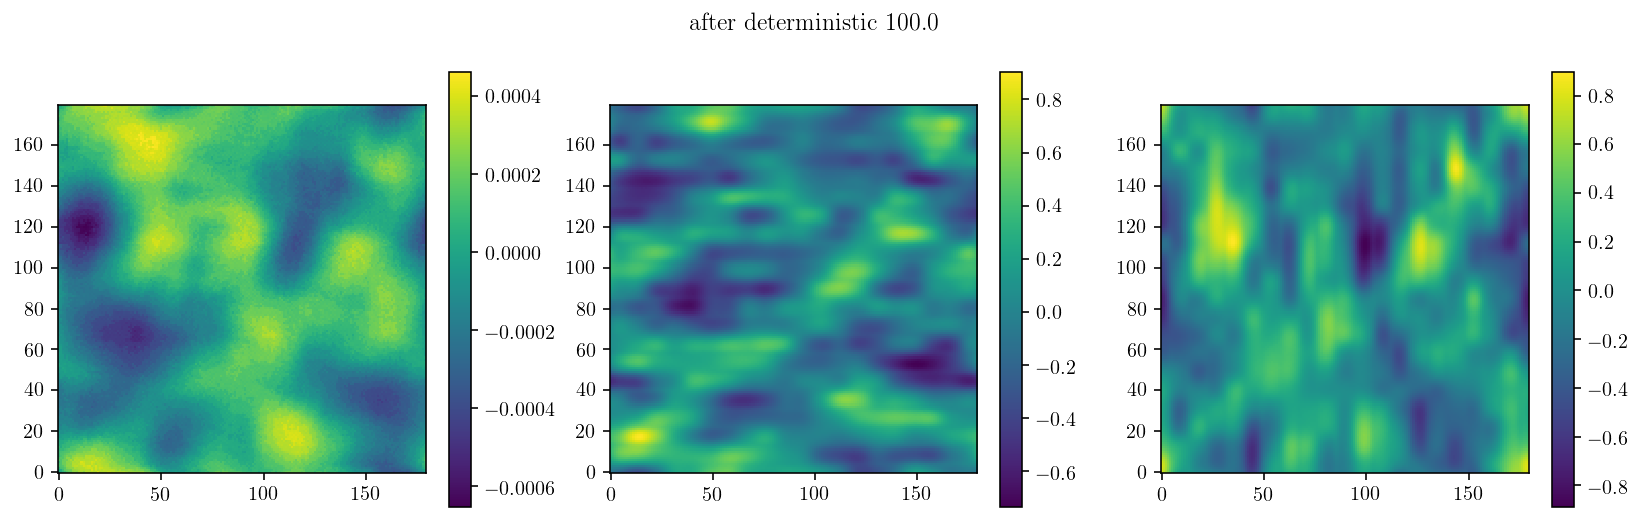

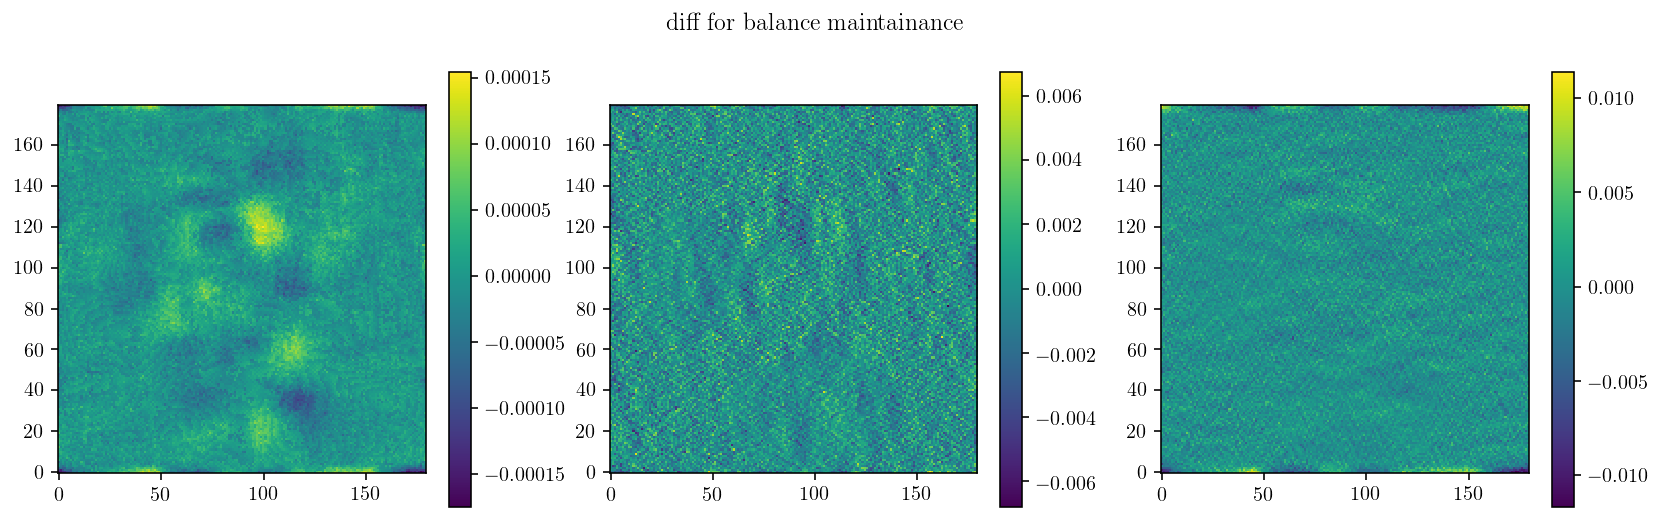

In [21]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()

nx = domain_size
ny = domain_size

dx = float(width/nx)
dy = float(height/ny)

bc = Common.BoundaryConditions(2,2,2,2)
ghosts = np.array([2,2,2,2])
dataShape = (ny + ghosts[1]+ghosts[3], 
             nx + ghosts[0]+ghosts[2])

Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
Hi_flat = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*60
eta0 = np.zeros(dataShape, dtype=np.float32);
hu0 = np.zeros(dataShape, dtype=np.float32);
hv0 = np.zeros(dataShape, dtype=np.float32);
angle = np.zeros(dataShape, dtype=np.float32);

dt = end_time / domain_size
initH(Hi, ghosts, domain_size*2+1)
#initEtaFV(eta0, ghosts, domain_size*2)
#initHU(hu0, ghosts)
#initHV(hv0, ghosts)
angle=initAngle(angle)
print("min, max, shape of angle: ", angle.min(), angle.max(), angle.shape)
print('-np.pi/2:', -np.pi/2)

#Hi = Hi + 400

# Model error parameters
model_error_args = {
    "small_scale_perturbation": True,
    "small_scale_perturbation_amplitude": 1.0e-4, #1.0e-5,
    "small_scale_perturbation_interpolation_factor": 9, #9 #5
}


#Initialize simulator
sim = CDKLM16.CDKLM16(gpu_ctx, 
                      eta0, hu0, hv0, Hi+500, #_flat,
                      nx, ny, 
                      dx, dy, dt, 
                      g, f, r, coriolis_beta=beta,
                      angle=angle, 
                      boundary_conditions=bc,
                      **model_error_args)

print('nx, ny', sim.nx, sim.ny)
print('dx, dy', sim.dx, sim.dx)
print('domain size (Lx, Ly):', (sim.nx*sim.dx, sim.ny*sim.dy))
print('f, beta', sim.f, sim.coriolis_beta)

def plotImshow(data, title=' '):
    fig = plt.figure(figsize=(5,4))
    plt.imshow(data, origin='lower', interpolation='None')
    plt.colorbar()
    plt.title(title)
    
def plotImshow3(eta, hu, hv, title=' '):
    fig = plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(eta, origin='lower', interpolation='None')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(hu, origin='lower', interpolation='None')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(hv, origin='lower', interpolation='None')
    plt.colorbar()
    plt.suptitle(title)
    
#eta1, hu1, hv1 = sim.download(interior_domain_only=True)
#plotImshow3(eta1, hu1, hv1)

#sim.step(sim.dt)

sim.perturbState()

#sim.step(sim.dt)

eta1, hu1, hv1 = sim.download(interior_domain_only=True)
plotImshow3(eta1, hu1, hv1, 'perturb')

#plotImshow3(eta2-eta1, hu2-hu1, hv2-hv1)

Hi, Hm = sim.downloadBathymetry(interior_domain_only=True)
print('Hi.shape, Hm.shape', Hi.shape, Hm.shape)
plotImshow(Hi, 'bathymetry')

print("min, max of hu:    ", hu1.min(), hu1.max())
print("min, max of hv:    ", hv1.min(), hv1.max())
print("min, max of angle: ", angle.min(), angle.max())


for i in range(10):
    sim.step(10, apply_stochastic_term=False)

    eta2, hu2, hv2 = sim.download(interior_domain_only=True)
    plotImshow3(eta2, hu2, hv2, 'after deterministic ' + str(sim.t))


plotImshow3(eta2-eta1, hu2-hu1, hv2-hv1, 'diff for balance maintainance')
error_norm = np.linalg.norm(eta2-eta1)
rel_error_norm = np.linalg.norm(eta2-eta1)/np.linalg.norm(eta1)

print('error norm:    ', error_norm)
print('rel error norm:', rel_error_norm)
